In [1]:
import pandas as pd
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from matplotlib import dates, ticker
from datetime import datetime
from subprocess import Popen, PIPE

In [2]:
ap_log_filename = '' # autopilot ULOG file name
dp_old_filename = 'SDP33_tp_log_2020-03-15T11:46:44.706178.csv' # log file from older windgauge
dp_new_filename = 'SDP33_tp_log_2020-03-15T11:50:09.457973.csv' # log file from newer windgauge

ap_log_title = ap_log_filename.sp'lit('/')[-1].split('.')[0]

In [3]:
# Convert 'airspeed' and 'vehicle_gps_position' messages from ULOG to CSV
command = "ulog2csv " + ap_log_filename + " -m 'airspeed,vehicle_gps_position'"
print("Converting ULOG file to CSV...")

process = Popen(command, stderr=PIPE, shell=True)
process.wait()
err_msg = process.stderr.read()

if len(err_msg) > 5:
    print(err_msg)
else:
    print("done!")

Converting ULOG file to CSV...
done!


In [4]:
# Load data files
dp_old_log = pd.read_csv(dp_old_filename, sep=';')
dp_new_log = pd.read_csv(dp_new_filename, sep=';')
air_spd_log = pd.read_csv(ap_log_title + '_airspeed_0.csv', sep=',')
gps_ts_log = pd.read_csv(ap_log_title + '_vehicle_gps_position_0.csv', sep=',')

In [5]:
data = {'ts': pd.to_datetime(air_spd_log['timestamp']), 'air_spd':air_spd_log['indicated_airspeed_m_s']}
air_spd_df = pd.DataFrame(data)

data = {'ts': pd.to_datetime(gps_ts_log['timestamp']), 'timestamp': pd.to_datetime(gps_ts_log['time_utc_usec'], unit='us')}
gps_ts_df = pd.DataFrame(data)

autopilot_df = pd.merge_asof(gps_ts_df, air_spd_df, on='ts')
del autopilot_df['ts']


data = {'timestamp': pd.to_datetime(dp_old_log['system_timestamp']), 'dp_old': -dp_old_log['diff_press[Pa]']}
dp_old_df = pd.DataFrame(data)

data = {'timestamp': pd.to_datetime(dp_new_log['system_timestamp']), 'dp_new': -dp_new_log['diff_press[Pa]']}
dp_new_df = pd.DataFrame(data)

windgauge_df = pd.merge_asof(dp_old_df, dp_new_df, on='timestamp', direction="nearest")

df = pd.merge_asof(autopilot_df, windgauge_df, on='timestamp')
df.index = df['timestamp']

date = pd.to_datetime(df['timestamp'][0]).strftime('%d.%m.%Y')
date_save = pd.to_datetime(df['timestamp'][0]).strftime('%d_%m_%Y_%H_%M_%S')


In [6]:
# print(df)

In [7]:
xBound = False

if xBound:
    start = pd.Timestamp('2020-03-15 11:53:00')
    end = pd.Timestamp('2020-03-15 11:55:00')
else:
    start = df['timestamp'].iloc[0]
    end = df['timestamp'].iloc[-1]

In [8]:
## Data filtering

c1 = 21 # filter window lenght
c2 = 3 # filter degree

df['dp_old_filt'] = signal.savgol_filter(df['dp_old'], c1, c2)
df['dp_new_filt'] = signal.savgol_filter(df['dp_new'], c1, c2)
df['air_spd_filt'] = signal.savgol_filter(df['air_spd'], c1, c2)


In [9]:
## Data normalisation
max_dp_old = np.max(df['dp_old'][start:end])
max_dp_new = np.max(df['dp_new'][start:end])
max_air_spd = np.max(df['air_spd'][start:end])

mean_dp_old = np.mean(df['dp_old'][start:end])
mean_dp_new = np.mean(df['dp_new'][start:end])
mean_air_spd = np.mean(df['air_spd'][start:end])

df['dp_old_norm_max'] = df['dp_old']/max_dp_old
df['dp_new_norm_max'] = df['dp_new']/max_dp_new
df['air_spd_norm_max'] = df['air_spd']/max_air_spd

df['dp_old_norm_mean'] = df['dp_old']/mean_dp_old
df['dp_new_norm_mean'] = df['dp_new']/mean_dp_new
df['air_spd_norm_mean'] = df['air_spd']/mean_air_spd

max_norm_mean = np.max([np.max(df['dp_old_norm_mean']),np.max(df['dp_new_norm_mean']) ,np.max(df['air_spd_norm_mean'])])
# print(max_norm_mean)


max_dp_old_filt = np.max(df['dp_old_filt'][start:end])
max_dp_new_filt = np.max(df['dp_new_filt'][start:end])
max_air_spd_filt = np.max(df['air_spd_filt'][start:end])

mean_dp_old_filt = np.mean(df['dp_old_filt'][start:end])
mean_dp_new_filt = np.mean(df['dp_new_filt'][start:end])
mean_air_spd_filt = np.mean(df['air_spd_filt'][start:end])

df['dp_old_filt_norm_max'] = df['dp_old_filt']/max_dp_old_filt
df['dp_new_filt_norm_max'] = df['dp_new_filt']/max_dp_new_filt
df['air_spd_filt_norm_max'] = df['air_spd_filt']/max_air_spd_filt

df['dp_old_filt_norm_mean'] = df['dp_old_filt']/mean_dp_old_filt
df['dp_new_filt_norm_mean'] = df['dp_new_filt']/mean_dp_new_filt
df['air_spd_filt_norm_mean'] = df['air_spd_filt']/mean_air_spd_filt

max_filt_norm_mean = np.max([np.max(df['dp_old_filt_norm_mean']),np.max(df['dp_new_filt_norm_mean']) ,np.max(df['air_spd_filt_norm_mean'])])
# print(max_filt_norm_mean)

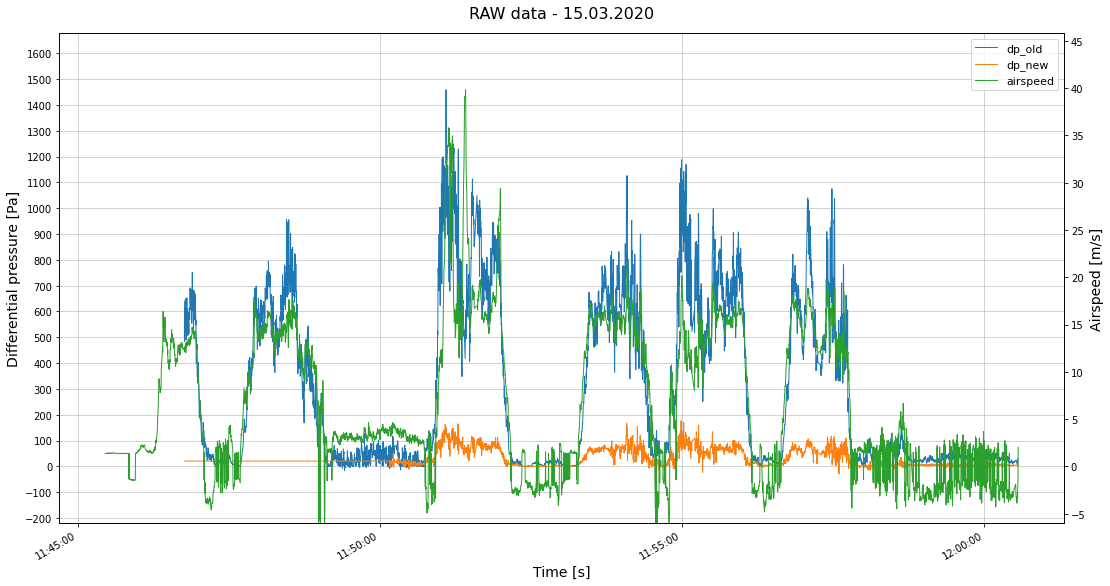

In [10]:
## RAW data graph

fig = plt.figure(figsize=(18,10))
plt.title('RAW data - ' + date, fontsize = 16, pad=15)
ax1 = df.dp_old.plot( linewidth = 1, label = 'dp_old')
ax1.set_ylabel('Differential pressure [Pa]', fontsize = 14)
y_ax_max = np.max([max_dp_old, max_dp_new])
ax1.set_ylim([-0.15*y_ax_max,1.15*y_ax_max])

ax1.yaxis.set_major_locator(ticker.MultipleLocator(base=100) )
ax1.xaxis.set_major_formatter(dates.DateFormatter('%H:%M:%S'))
#ax1.xaxis.set_major_locator(dates.MinuteLocator(interval=20))

if xBound:
    ax1.set_xlim([start, end])
    ax1.xaxis.set_major_locator(dates.SecondLocator(interval=20))

ax2 = df.dp_new.plot( linewidth = 1, label = 'dp_new')

ax3 = df.air_spd.plot(secondary_y=True, linewidth = 1, label = 'airspeed')
ax3.set_ylabel('Airspeed [m/s]',fontsize = 14)
ax3.yaxis.set_major_locator(ticker.MultipleLocator(base=5) )
y_ax_max = np.max(max_air_spd)
ax3.set_ylim([-0.15*y_ax_max,1.15*y_ax_max])

ax1.set_xlabel('Time [s]', fontsize = 14)
ax1.grid('on', which='major' , alpha = 0.7)

handles,labels = [],[]
for ax in fig.axes:
    for h,l in zip(*ax.get_legend_handles_labels()):
        handles.append(h)
        labels.append(l)

plt.legend(handles,labels, fontsize = 11)
plt.savefig(date_save + '_raw.png', dpi=200)
plt.show()



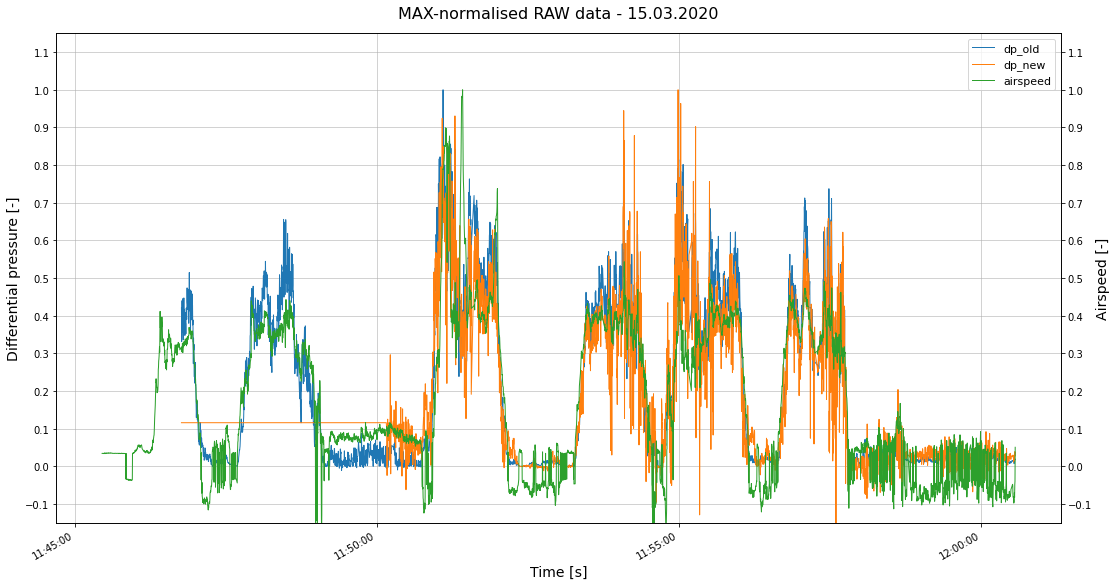

In [11]:
## MAX-normalised RAW data graph

fig = plt.figure(figsize=(18,10))
plt.title('MAX-normalised RAW data - ' + date, fontsize = 16, pad=15)
ax1 = df.dp_old_norm_max.plot( linewidth = 1, label = 'dp_old')
ax1.set_ylabel('Differential pressure [-]', fontsize = 14)
ax1.set_ylim([-0.15,1.15])

ax1.yaxis.set_major_locator(ticker.MultipleLocator(base=0.1) )
ax1.xaxis.set_major_formatter(dates.DateFormatter('%H:%M:%S'))
#ax1.xaxis.set_major_locator(dates.MinuteLocator(interval=20))

if xBound:
    ax1.set_xlim([start, end])
    ax1.xaxis.set_major_locator(dates.SecondLocator(interval=20))

ax2 = df.dp_new_norm_max.plot( linewidth = 1, label = 'dp_new')

ax3 = df.air_spd_norm_max.plot(secondary_y=True, linewidth = 1, label = 'airspeed')
ax3.set_ylabel('Airspeed [-]',fontsize = 14)
ax3.yaxis.set_major_locator(ticker.MultipleLocator(base=0.1) )

ax3.set_ylim([-0.15,1.15])
ax1.set_xlabel('Time [s]', fontsize = 14)

ax1.grid('on', which='major' , alpha = 0.7)

handles,labels = [],[]
for ax in fig.axes:
    for h,l in zip(*ax.get_legend_handles_labels()):
        handles.append(h)
        labels.append(l)

plt.legend(handles,labels, fontsize = 11)
plt.savefig(date_save + '_max_norm' , dpi=200)
plt.show()


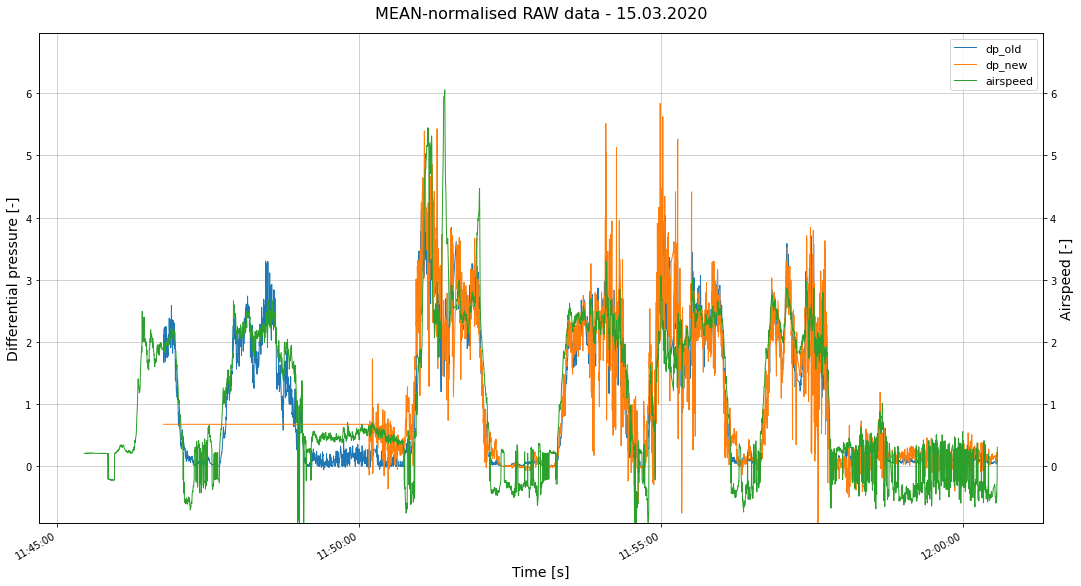

In [12]:
## MEAN-normalised RAW data graph

fig = plt.figure(figsize=(18,10))
plt.title('MEAN-normalised RAW data - ' + date, fontsize = 16, pad=15)
ax1 = df.dp_old_norm_mean.plot( linewidth = 1, label = 'dp_old')
ax1.set_ylabel('Differential pressure [-]', fontsize = 14)
y_ax_max = max_norm_mean
ax1.set_ylim([-0.15*y_ax_max,1.15*y_ax_max])

ax1.yaxis.set_major_locator(ticker.MultipleLocator(base=1) )
ax1.xaxis.set_major_formatter(dates.DateFormatter('%H:%M:%S'))
#ax1.xaxis.set_major_locator(dates.MinuteLocator(interval=20))

if xBound:
    ax1.set_xlim([start, end])
    ax1.xaxis.set_major_locator(dates.SecondLocator(interval=20))

ax2 = df.dp_new_norm_mean.plot( linewidth = 1, label = 'dp_new')

ax3 = df.air_spd_norm_mean.plot(secondary_y=True, linewidth = 1, label = 'airspeed')
ax3.set_ylabel('Airspeed [-]',fontsize = 14)
ax3.yaxis.set_major_locator(ticker.MultipleLocator(base=1) )

y_ax_max = max_norm_mean
ax3.set_ylim([-0.15*y_ax_max,1.15*y_ax_max])
ax1.set_xlabel('Time [s]', fontsize = 14)

ax1.grid('on', which='major' , alpha = 0.7)

handles,labels = [],[]
for ax in fig.axes:
    for h,l in zip(*ax.get_legend_handles_labels()):
        handles.append(h)
        labels.append(l)

plt.legend(handles,labels, fontsize = 11)
plt.savefig(date_save + '_mean_norm' , dpi=200)
plt.show()

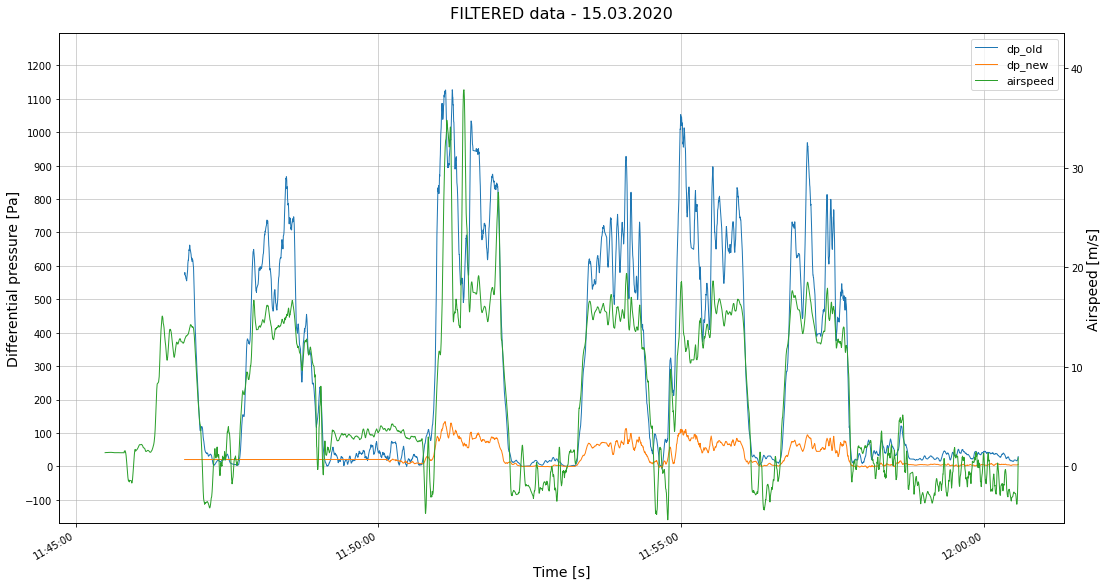

In [13]:
## FILTERED data graph

fig = plt.figure(figsize=(18,10))
plt.title('FILTERED data - ' + date, fontsize = 16, pad=15)
ax1 = df.dp_old_filt.plot( linewidth = 1, label = 'dp_old')
ax1.set_ylabel('Differential pressure [Pa]', fontsize = 14)
y_ax_max = np.max([max_dp_old_filt, max_dp_new_filt])
ax1.set_ylim([-0.15*y_ax_max,1.15*y_ax_max])

ax1.yaxis.set_major_locator(ticker.MultipleLocator(base=100) )
ax1.xaxis.set_major_formatter(dates.DateFormatter('%H:%M:%S'))
#ax1.xaxis.set_major_locator(dates.MinuteLocator(interval=20))

if xBound:
    ax1.set_xlim([start, end])
    ax1.xaxis.set_major_locator(dates.SecondLocator(interval=20))

ax2 = df.dp_new_filt.plot( linewidth = 1, label = 'dp_new')

ax3 = df.air_spd_filt.plot(secondary_y=True, linewidth = 1, label = 'airspeed')
ax3.set_ylabel('Airspeed [m/s]',fontsize = 14)
y_ax_max = np.max(max_air_spd_filt)
ax3.set_ylim([-0.15*y_ax_max,1.15*y_ax_max])
ax1.set_xlabel('Time [s]', fontsize = 14)

ax1.grid('on', which='major' , alpha = 0.7)

handles,labels = [],[]
for ax in fig.axes:
    for h,l in zip(*ax.get_legend_handles_labels()):
        handles.append(h)
        labels.append(l)

plt.legend(handles,labels, fontsize = 11)
plt.savefig(date_save + '_filt' , dpi=200)
plt.show()

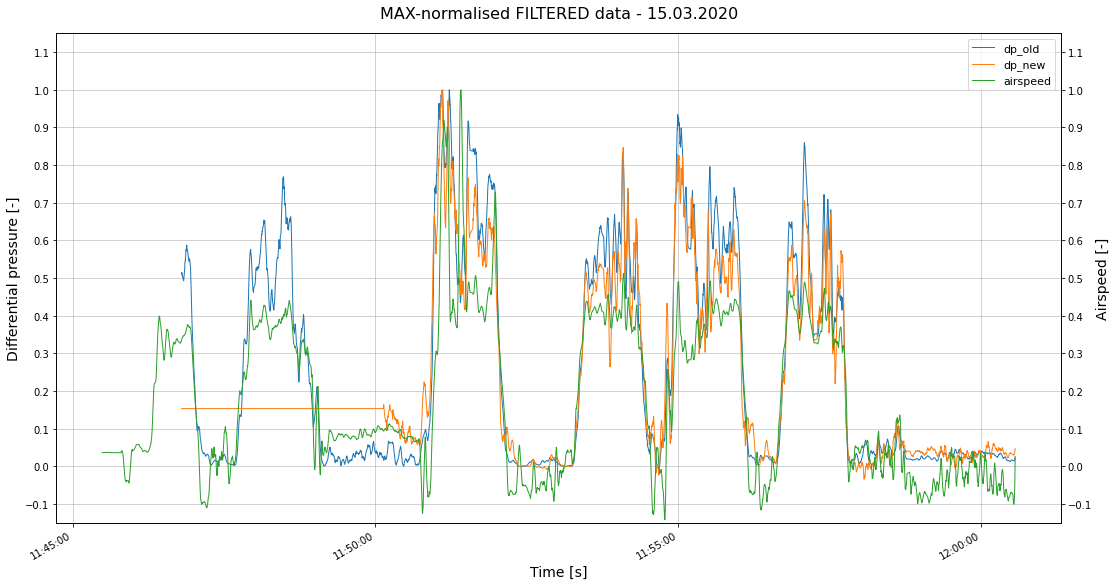

In [14]:
## MAX-normalised FILTERED data graph

fig = plt.figure(figsize=(18,10))
plt.title('MAX-normalised FILTERED data - ' + date, fontsize = 16, pad=15)
ax1 = df.dp_old_filt_norm_max.plot( linewidth = 1, label = 'dp_old')
ax1.set_ylabel('Differential pressure [-]', fontsize = 14)
ax1.set_ylim([-0.15,1.15])

ax1.yaxis.set_major_locator(ticker.MultipleLocator(base=0.1) )
ax1.xaxis.set_major_formatter(dates.DateFormatter('%H:%M:%S'))
#ax1.xaxis.set_major_locator(dates.MinuteLocator(interval=20))

if xBound:
    ax1.set_xlim([start, end])
    ax1.xaxis.set_major_locator(dates.SecondLocator(interval=20))

ax2 = df.dp_new_filt_norm_max.plot( linewidth = 1, label = 'dp_new')

ax3 = df.air_spd_filt_norm_max.plot(secondary_y=True, linewidth = 1, label = 'airspeed')
ax3.set_ylabel('Airspeed [-]',fontsize = 14)
ax3.yaxis.set_major_locator(ticker.MultipleLocator(base=0.1) )

ax3.set_ylim([-0.15,1.15])
ax1.set_xlabel('Time [s]', fontsize = 14)

ax1.grid('on', which='major' , alpha = 0.7)

handles,labels = [],[]
for ax in fig.axes:
    for h,l in zip(*ax.get_legend_handles_labels()):
        handles.append(h)
        labels.append(l)

plt.legend(handles,labels, fontsize = 11)
plt.savefig(date_save + '_filt_max_norm' , dpi=200)
plt.show()

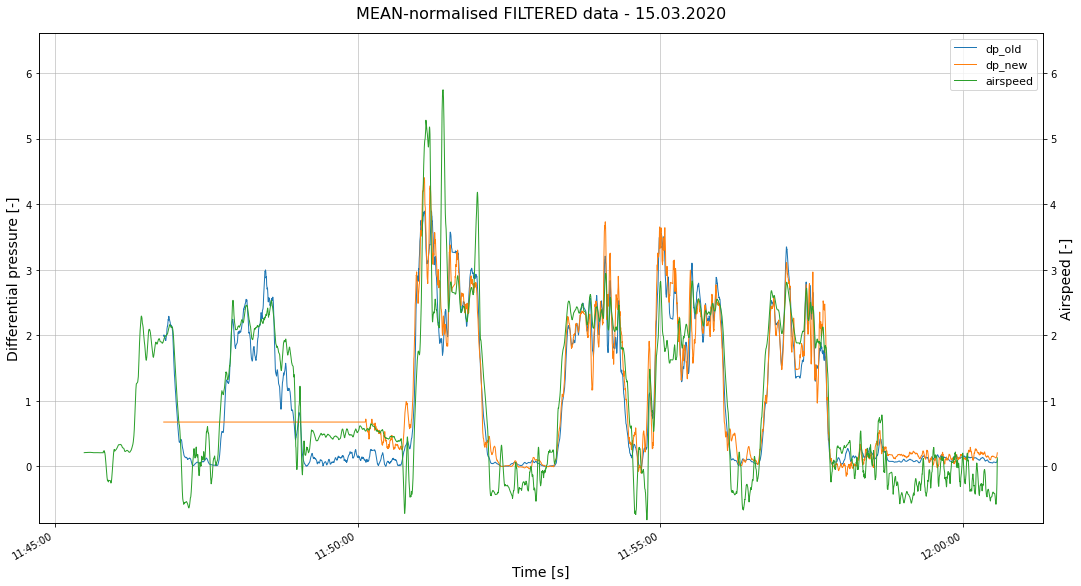

In [15]:
## MEAN-normalised FILTERED data graph

fig = plt.figure(figsize=(18,10))
plt.title('MEAN-normalised FILTERED data - ' + date, fontsize = 16, pad=15)
ax1 = df.dp_old_filt_norm_mean.plot( linewidth = 1, label = 'dp_old')
ax1.set_ylabel('Differential pressure [-]', fontsize = 14)
y_ax_max = max_filt_norm_mean
ax1.set_ylim([-0.15*y_ax_max,1.15*y_ax_max])

ax1.yaxis.set_major_locator(ticker.MultipleLocator(base=1) )
ax1.xaxis.set_major_formatter(dates.DateFormatter('%H:%M:%S'))
#ax1.xaxis.set_major_locator(dates.MinuteLocator(interval=20))

if xBound:
    ax1.set_xlim([start, end])
    ax1.xaxis.set_major_locator(dates.SecondLocator(interval=20))

ax2 = df.dp_new_filt_norm_mean.plot( linewidth = 1, label = 'dp_new')

ax3 = df.air_spd_filt_norm_mean.plot(secondary_y=True, linewidth = 1, label = 'airspeed')
ax3.set_ylabel('Airspeed [-]',fontsize = 14)
ax3.yaxis.set_major_locator(ticker.MultipleLocator(base=1) )

y_ax_max = max_filt_norm_mean
ax3.set_ylim([-0.15*y_ax_max,1.15*y_ax_max])
ax1.set_xlabel('Time [s]', fontsize = 14)

ax1.grid('on', which='major' , alpha = 0.7)

handles,labels = [],[]
for ax in fig.axes:
    for h,l in zip(*ax.get_legend_handles_labels()):
        handles.append(h)
        labels.append(l)

plt.legend(handles,labels, fontsize = 11)
plt.savefig(date_save + '_filt_mean_norm' , dpi=200)
plt.show()